In [1]:
cd /home/ubuntu/DistMEC/

/home/ubuntu/DistMEC


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from classes.User import *
from classes.solver import *
from classes.Server import *
from classes.distributed_utils import *

In [3]:
def copy_usr_loc(Users1, Users2):
    
    for u in range(len(Users1)):
        Users2[u].usr_place = Users1[u].usr_place
        Users2[u].expected_time = Users1[u].expected_time
        
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [14]:
# System Parameters
T = 5000
num_users = 10
num_svrs = 16
num_locs = 9
mu = np.random.uniform(low=0, high = 1, size = [num_users, num_svrs])
ceiling = 20
# w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])

# Generate visitng locations and server locations
space_1d_dim = 10 #4 for small, 10 for big
usr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_locs)
svr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_svrs)

# Create Users
Users = []
for i in range(num_users):
    Users += [User(usr_locs,svr_locs,mu[i],i,
                  max_dist = 7, threshold_dist = 6, self_weight = 1 - 0.95, P = None, ceiling = ceiling,
                  sticky_mode = False)]
    
# Create Servers
Servers = []
for i in range(num_svrs):
    Servers += [Server(svr_locs[i],mu,i)]

# Recorded Values - reservation
regret = np.zeros(T)
collision_count = np.zeros(T)
optimal_reward = np.zeros(T)

In [15]:
# Explore rounds are common/shared across all users
explore_rounds(Users, num_users, Servers, mu, regret, collision_count, optimal_reward,
               usr_move_flag = True, rounds=1)

# Make copies of values for worst case
Users_w = copy.deepcopy(Users)
regret_w = copy.deepcopy(regret)
collision_count_w = copy.deepcopy(collision_count)

# For sticky Case
Users_s = copy.deepcopy(Users)
regret_s = copy.deepcopy(regret)
collision_count_s = copy.deepcopy(collision_count)
for u in Users_s:
    u.sticky_mode = True

for t in range(i+1, T):
    w = obtain_w(Users, len(Users), len(Servers))
    optimal = offline_optimal_action(w, mu)
    optimal_reward[t] = optimal[1]
    play_round(Users, Servers, mu, regret, collision_count, 
               usr_move_flag = True, debugger = False, reservation_mode = True, optimal =optimal)
    play_round(Users_w, Servers, mu, regret_w, collision_count_w, 
               usr_move_flag = False, debugger=False, reservation_mode = False, optimal=optimal)
    play_round(Users_s, Servers, mu, regret_s, collision_count_s, 
               usr_move_flag = False, debugger=False, reservation_mode = True, optimal=optimal)
    copy_usr_loc(Users, Users_w)
    copy_usr_loc(Users, Users_s)

In [16]:
# Obtain reward values
reward = optimal_reward - regret
reward_w = optimal_reward - regret_w
reward_s = optimal_reward - regret_s
threshold = 1

# reward[reward <=  0] = threshold
reward_w[reward_w <= 0] = reward_s[reward_w <=  0]# threshold

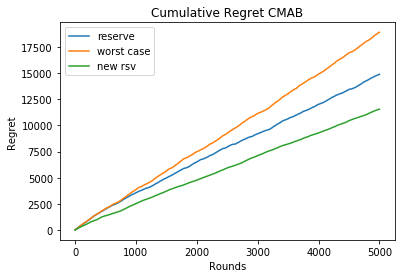

In [17]:
plt.plot(np.cumsum(regret), label = 'reserve')
plt.plot(np.cumsum(regret_w), label = 'worst case')
plt.plot(np.cumsum(regret_s), label = 'new rsv')
plt.title('Cumulative Regret CMAB')
plt.xlabel('Rounds')
plt.ylabel('Regret')
plt.legend()

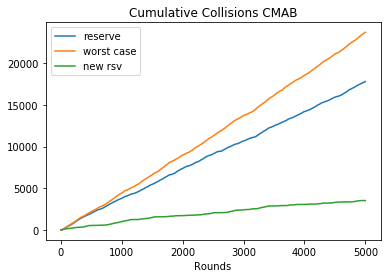

In [18]:
plt.plot(np.cumsum(collision_count), label = 'reserve')
plt.plot(np.cumsum(collision_count_w), label = 'worst case')
plt.plot(np.cumsum(collision_count_s), label = 'new rsv')
plt.title('Cumulative Collisions CMAB')
plt.xlabel('Rounds')
plt.legend()

reg 1.3591443531547576
new 1.6072060799899806


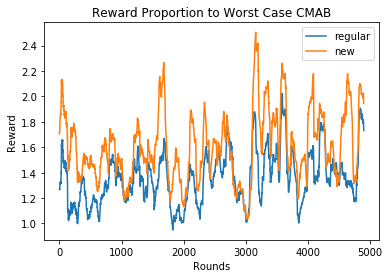

In [19]:
# data preprocessing
n = 100
y1 = np.divide(reward, reward_w)
y1 = moving_average(y1,n=n)

y2 = np.divide(reward_s, reward_w)
y2 = moving_average(y2, n=n)

plt.plot(y1, label = 'regular')
plt.plot(y2, label = 'new')
plt.title('Reward Proportion to Worst Case CMAB')
plt.xlabel('Rounds')
plt.ylabel('Reward')
plt.legend()

print('reg',np.mean(np.divide(reward, reward_w)))
print('new',np.mean(np.divide(reward_s, reward_w)))


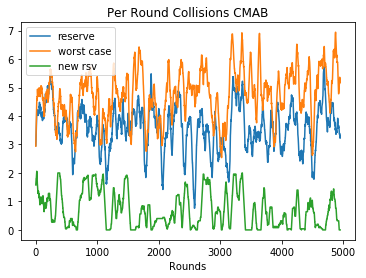

In [21]:
m = 50
plt.plot(moving_average(collision_count,m), label = 'reserve')
plt.plot(moving_average(collision_count_w,m), label = 'worst case')
plt.plot(moving_average(collision_count_s,m), label = 'new rsv')
plt.title('Per Round Collisions CMAB')
plt.xlabel('Rounds')
plt.legend()

